In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

In [ ]:
!cp -r "/content/drive/My Drive/marble" "marble"

In [ ]:
!ls "/content/marble"

'marble datasets'  'MINST Genetic Algorithm.ipynb'


In [ ]:
#count the number of images in respective directory
import fnmatch
import os
print( "Total number of images in CLASS A", len(fnmatch.filter(os.listdir("/content/marble/marble datasets/CLASS A"), '*.jpg')));
print( "Total number of images in CLASS B", len(fnmatch.filter(os.listdir("/content/marble/marble datasets/CLASS B"), '*.jpg')));
print( "Total number of images in CLASS C", len(fnmatch.filter(os.listdir("/content/marble/marble datasets/CLASS C"), '*.jpg')));

Total number of images in CLASS A 164
Total number of images in CLASS B 245
Total number of images in CLASS C 494


In [ ]:
# create final dataset.the training  dataset consits of (0.8 * 0.8 * T), the valdation dataset (0.2 * 0.8 * T) and (0.2 * T) testing images.
# x_train: Numpy arrays of the images of the training dataset
# y_train: Labels of the training dataset
# x_test: Numpy arrays of the images of the testing dataset
# y_test: Labels of the testing dataset
# x_val: Numpy arrays of the images of the validation dataset
# y_val: Labels of the validation dataset

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [ ]:
# split dataset into train_test_folder
! pip install python_splitter 
import python_splitter
python_splitter.split_from_folder("/content/marble/marble datasets", train=0.64, test=0.16, val=0.2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✅Checking SOURCE directory...
0.64 0.2 0.16
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


In [ ]:
train_path="Train_Test_Folder/train"
test_path="Train_Test_Folder/test"
val_path="Train_Test_Folder/val"

In [ ]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)


In [ ]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)


In [ ]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

In [ ]:
# _train,x_test, and x_val divided by 255.0 for normalization.
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [ ]:
train_x.shape,test_x.shape,val_x.shape

((576, 224, 224, 3), (181, 224, 224, 3), (146, 224, 224, 3))

In [ ]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
#labels of the corresponding datasets using ImageDataGenerator.
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')


Found 576 images belonging to 3 classes.
Found 181 images belonging to 3 classes.
Found 146 images belonging to 3 classes.


In [ ]:
training_set.class_indices

{'CLASS A': 0, 'CLASS B': 1, 'CLASS C': 2}

In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes
train_y.shape,test_y.shape,val_y.shape

((576,), (181,), (146,))

In [ ]:
from tensorflow.core.protobuf.config_pb2 import ConfigProto
# from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.python.client.session import InteractiveSession
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False




In [ ]:

def init():
    # our layers - you can add more if you want
    x = Flatten()(vgg.output)
    prediction = Dense(3, activation='softmax')(x)
    # create a model object 
    model = Model(inputs=vgg.input, outputs=prediction)
    # tell the model what cost and optimization method to use
    model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer="adam",
      metrics=['accuracy']
    )
    print(model.summary())
    return model


def train(models):
    losses = []
    early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
    for i in range(len(models)):
        history =  models[i].fit(
                    train_x,
                    train_y,
                    validation_data=(val_x,val_y),
                    epochs=10,
                    callbacks=[early_stop],
                    batch_size=32,shuffle=True)
        losses.append(round(history.history['loss'][-1], 4))
    return models, losses


In [ ]:
import random

no_of_generations = 10
no_of_individuals = 3
mutate_factor = 0.05
individuals = []

layers = []


def mutate(new_individual):
    for layer in layers:
        for bias in range(len(new_individual.layers[layer].get_weights()[1])):
            n = random.random()
            if n < mutate_factor:
                new_individual.layers[layer].get_weights(
                )[1][bias] *= random.uniform(-0.5, 0.5)

    for layer in layers:
        for weight in new_individual.layers[layer].get_weights()[0]:
            n = random.random()
            if n < mutate_factor:
                for j in range(len(weight)):
                    if random.random() < mutate_factor:
                        new_individual.layers[layer].get_weights(
                        )[0][j] *= random.uniform(-0.5, 0.5)

    return new_individual


def crossover(individuals_param):
    new_individuals = [individuals_param[0], individuals_param[1]]

    for j in range(2, no_of_individuals):
        if j < (no_of_individuals - 2):
            if j == 2:
                parentA = random.choice(individuals_param[:3])
                parentB = random.choice(individuals_param[:3])
            else:
                parentA = random.choice(individuals_param[:])
                parentB = random.choice(individuals_param[:])

            for j in layers:
                print(parentA.layers)
                temp = parentA.layers[j].get_weights()[1]
                parentA.layers[j].get_weights(
                )[1] = parentB.layers[j].get_weights()[1]
                parentB.layers[j].get_weights()[1] = temp

            new_individual = random.choice([parentA, parentB])

        else:
            new_individual = random.choice(individuals_param[:])

        new_individuals.append(mutate(new_individual))
        new_individuals.append(new_individual)

    return new_individuals


def evolve(individuals_param, losses_param):
    sorted_y_idx_list = sorted(range(len(losses_param)), key=lambda x: losses_param[x])
    individuals_param = [individuals_param[x] for x in sorted_y_idx_list]

    # winners = individuals[:6]

    new_individuals = crossover(individuals_param)

    return new_individuals



 #main ops
for i in range(no_of_individuals):
    individuals.append(init())

for generation in range(no_of_generations):
    individuals, losses = train(individuals)
    print(losses)

    individuals = evolve(individuals, losses)

individuals[0].save("cnn1.h5")

Epoch 1/10
18/18 [==============================] - 16s 343ms/step - loss: 1.0011 - accuracy: 0.5972 - val_loss: 0.9730 - val_accuracy: 0.6438
Epoch 2/10
18/18 [==============================] - 4s 219ms/step - loss: 0.7382 - accuracy: 0.6892 - val_loss: 0.9900 - val_accuracy: 0.6164
Epoch 3/10
18/18 [==============================] - 4s 220ms/step - loss: 0.6140 - accuracy: 0.7448 - val_loss: 0.8209 - val_accuracy: 0.6370
Epoch 4/10
18/18 [==============================] - 4s 221ms/step - loss: 0.5299 - accuracy: 0.7847 - val_loss: 0.8876 - val_accuracy: 0.6164
Epoch 5/10
18/18 [==============================] - 4s 221ms/step - loss: 0.4610 - accuracy: 0.8142 - val_loss: 0.9364 - val_accuracy: 0.6096
Epoch 6/10
18/18 [==============================] - 4s 222ms/step - loss: 0.4011 - accuracy: 0.8594 - val_loss: 1.0127 - val_accuracy: 0.6370
Epoch 7/10
18/18 [==============================] - 4s 222ms/step - loss: 0.4520 - accuracy: 0.8212 - val_loss: 0.9722 - val_accuracy: 0.6370
Epoch

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
model = load_model("cnn.h5")


In [ ]:
predicted_classes = model.predict(test_x)
predicted_classes = np.argmax(predicted_classes, axis=1)

6/6 [==============================] - 1s 181ms/step


In [ ]:
from sklearn.metrics import classification_report

num_classes = 3
target_names = [f"Class {i}" for i in range(num_classes)]

print(classification_report(test_y, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.25      0.12      0.16        33
     Class 1       0.45      0.51      0.48        49
     Class 2       0.77      0.85      0.81        99

    accuracy                           0.62       181
   macro avg       0.49      0.49      0.48       181
weighted avg       0.59      0.62      0.60       181



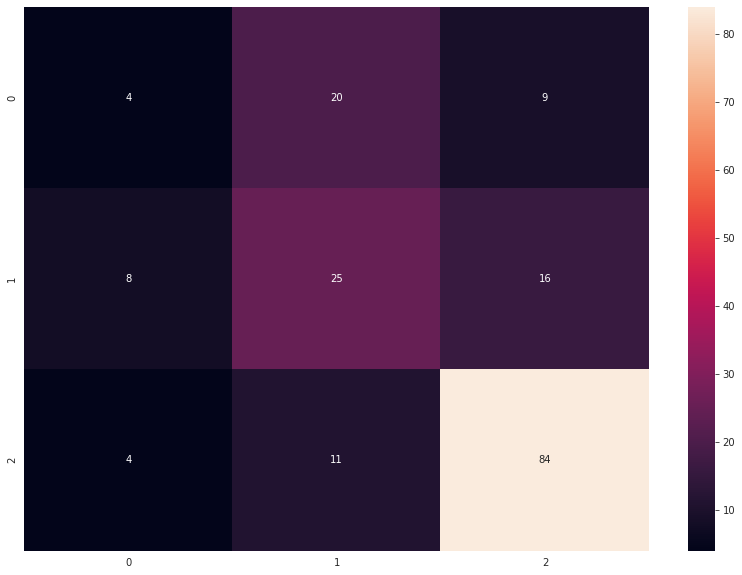

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

cm = confusion_matrix(test_y, predicted_classes)
plt.figure(figsize = (14,10))
sns.heatmap(cm, annot=True)

In [ ]:

random_idx = np.random.randint(0, len(train_x))
input_shape = (224, 224, 3)
output = model.predict(train_x[random_idx].reshape(1, *input_shape))
idx = np.argmax(output[0])
print("Model output: {0}".format(output))
print("Value with highest probability: {0} %{1:.2f}".format(idx, (output[0][idx]*100)))

1/1 [==============================] - 1s 691ms/step
Model output: [[0.9122951  0.03401291 0.05369195]]
Value with highest probability: 0 %91.23
